# Optimal Launch Angle and Barrels
For our 2024 WISD Hackathon project, we decided to analyze the ideal launch angle of the data given, as it relates to barrels. We did this by graphing out the bat path and trajectory for ideal swings.

In [85]:
import os
import numpy as np
import json
import pandas as pd
from pandas import DataFrame
import matplotlib.pyplot as plt
from scipy.interpolate import make_interp_spline, splprep, splev
from IPython.display import Image

### Load data

In [86]:
data_dir = 'anonymized-files-wisd' # this is what the file for the private data in our directory was
data_list = []

for filename in os.listdir(data_dir):
    with open(os.path.join(data_dir, filename), 'r') as file:
        for line in file:
            data_list.append(json.loads(line))

In [87]:
df = pd.json_normalize(data_list)
df.head()

,events,samples_ball,samples_bat,units.length,units.velocity,units.acceleration,units.angle,summary_acts.pitch.eventId,summary_acts.pitch.result,summary_acts.pitch.action,...,summary_score.runs.innings,summary_score.runs.play,summary_score.outs.inning,summary_score.outs.play,summary_score.count.balls.plateAppearance,summary_score.count.balls.play,summary_score.count.strikes.plateAppearance,summary_score.count.strikes.play,summary_acts.pitch.type,summary_acts.hit.eventId
0,[],"[{'time': 0.0103363, 'pos': [-1.61897673474511...",[{'event': 'No'}],foot,mph,mph/s,degree,0da10a0e-60ec-4714-b086-2001c7c01ed9,Ball,Called,...,"[{'team1': 0, 'team2': 0}]",0,0,0,1,1,2,0,NaN,NaN
1,[],"[{'time': 0.0296728, 'pos': [-0.80462875757812...",[{'event': 'No'}],foot,mph,mph/s,degree,7e78552a-4ab3-4667-a748-024841d6f9cc,Ball,Called,...,"[{'team1': 0, 'team2': 0}, {'team1': 0, 'team2...",0,1,0,0,1,0,0,NaN,NaN
2,[],"[{'time': 0.0382683, 'pos': [-1.08782534756770...",[{'event': 'No'}],foot,mph,mph/s,degree,ae2f8cfe-934d-486d-86f9-b05b6dcc8ffb,Ball,Called,...,"[{'team1': 1, 'team2': 0}, {'team1': 0, 'team2...",0,1,0,0,1,0,0,NaN,NaN
3,[],"[{'time': 0.0430903, 'pos': [-1.08296228279852...","[{'event': 'First', 'time': -0.430037700000000...",foot,mph,mph/s,degree,58e88a96-6f8a-4d37-894c-2f57ebad50e8,Ball,Called,...,"[{'team1': 0, 'team2': 0}, {'team1': 0, 'team2...",0,2,0,2,1,2,0,NaN,NaN
4,[],"[{'time': 0.0369063, 'pos': [-1.50433512772240...",[{'event': 'No'}],foot,mph,mph/s,degree,5f2aa62c-727d-4da3-82ef-0810a75dcba5,Ball,Called,...,"[{'team1': 0, 'team2': 0}, {'team1': 0, 'team2...",0,2,0,0,1,0,0,Sinker,NaN


In [88]:
len(df)

1251

In [89]:
df.dtypes

events                                          object
samples_ball                                    object
samples_bat                                     object
units.length                                    object
units.velocity                                  object
units.acceleration                              object
units.angle                                     object
summary_acts.pitch.eventId                      object
summary_acts.pitch.result                       object
summary_acts.pitch.action                       object
summary_acts.pitch.speed.mph                   float64
summary_acts.pitch.speed.kph                   float64
summary_acts.pitch.speed.mps                   float64
summary_acts.pitch.spin.rpm                    float64
summary_acts.hit.speed.mph                     float64
summary_acts.hit.speed.kph                     float64
summary_acts.hit.speed.mps                     float64
summary_acts.hit.spin.rpm                      float64
summary_sc

In [90]:
# check for rows with unit not foot, mph, mph/s
print('length: ', df['units.length'].unique())
print('velocity: ', df['units.velocity'].unique())
print('acceleration: ', df['units.acceleration'].unique())
print('angle: ', df['units.angle'].unique())

length:  ['foot']
velocity:  ['mph']
acceleration:  ['mph/s']
angle:  ['degree']


In [91]:
# df.to_csv('all_data.csv', index=False)

### Find groups of hits

In [92]:
save_dir = 'grouped_ids'

In [93]:
# filter for pitches with a hit
hit_df = df.dropna(subset=['summary_acts.hit.eventId'], ignore_index=True)
print(len(hit_df))

325


In [94]:
# expand events column (hit details) & remove unnecessary columns
events_df = pd.json_normalize(hit_df['events'].explode().to_list())
events_df = events_df.add_prefix('events.')
hit_df = hit_df.join(events_df)
hit_df = hit_df.drop(columns=['events', 'units.length', 'units.velocity', 'units.acceleration', 'units.angle',
                              'summary_acts.pitch.speed.kph', 'summary_acts.pitch.speed.mps', 
                              'summary_acts.hit.speed.kph', 'summary_acts.hit.speed.mps'])

In [95]:
angle_df = pd.DataFrame(hit_df['events.start.angle'].tolist(), columns=['events.spray_angle', 'events.launch_angle'])
hit_df = hit_df.drop(columns=['events.start.angle'])
hit_df = pd.concat([hit_df, angle_df], axis=1)

In [96]:
hit_df.iloc[0]

samples_ball                                   [{'time': -0.0046734, 'pos': [-1.0477735799342...
samples_bat                                    [{'event': 'First', 'time': -0.3944424, 'head'...
summary_acts.pitch.eventId                                  b120cf14-305c-442c-a739-c499bf61eec8
summary_acts.pitch.result                                                            HitIntoPlay
summary_acts.pitch.action                                                                    NaN
summary_acts.pitch.speed.mph                                                                84.0
summary_acts.pitch.spin.rpm                                                               2720.0
summary_acts.hit.speed.mph                                                                  84.0
summary_acts.hit.spin.rpm                                                                 1560.0
summary_score.runs.game.team1                                                                  4
summary_score.runs.game.team2 

#### Group by barrel

*"To be Barreled, a batted ball requires an exit velocity of at least 98 mph. At that speed, balls struck with a launch angle between 26-30 degrees always garner Barreled classification. For every mph over 98, the range of launch angles expands."* - mlb.com

In [97]:
# filter to hits that fulfill above requirement
# - launch angle: events.launch_angle
# - exit velocity: summary_acts.hit.speed.mph

barrel_df = hit_df[(hit_df['events.launch_angle'] >= 26) 
                & (hit_df['events.launch_angle'] <= 30)
                & (hit_df['summary_acts.hit.speed.mph'] >= 98)]
print(len(barrel_df))
print(barrel_df[['events.launch_angle', 'summary_acts.hit.speed.mph']])

7
     events.launch_angle  summary_acts.hit.speed.mph
26             28.158941                        98.0
30             28.101540                       100.0
111            28.688241                       105.0
188            29.320294                       100.0
242            28.543504                        99.0
275            28.753227                        99.0
298            29.489962                       104.0


In [98]:
barrel_ids = list(barrel_df['events.eventId'])
barrel_ids

['57d6343f-cdae-4517-acb4-ea73b838e2e9',
 'bee9aa56-bfdd-4871-ace1-178db56aa19a',
 'a44f0611-618d-41dd-bb9b-089140c3f317',
 '5fbf979d-ac7a-4f41-9498-2f94507ecba1',
 'f2f58c66-ea90-42cb-8d64-2ab98fe5c64a',
 '687e2c12-dff4-4580-9226-c111366746e5',
 'af219680-da54-4e43-8ea5-3ea020f3bc2d']

In [99]:
non_barrel_df = hit_df[(hit_df['events.launch_angle'] < 26) 
                    | (hit_df['events.launch_angle'] > 30)
                    | (hit_df['summary_acts.hit.speed.mph'] < 98)]
non_barrel_ids = list(non_barrel_df['events.eventId'])
len(non_barrel_ids)

318

In [100]:
barrel_group = {
    'barrel': barrel_ids,
    'other': non_barrel_ids
}
with open(os.path.join(save_dir, 'by_barrel.json'), 'w') as file:
    json.dump(barrel_group, file, indent=4)

#### Group by pitch count (strikes)

In [101]:
hit_df[['summary_score.count.balls.plateAppearance', 
        'summary_score.count.strikes.plateAppearance']]

,summary_score.count.balls.plateAppearance,summary_score.count.strikes.plateAppearance
0,0,0
1,2,0
2,1,2
3,0,2
4,1,1
...,...,...
320,1,1
321,0,2
322,0,2
323,2,2


In [102]:
# group by strike counts at the time of plate appearance
strikes_col = 'summary_score.count.strikes.plateAppearance'
event_id_col = 'events.eventId'

strike_ct_df = hit_df.groupby(strikes_col)[event_id_col].apply(list).reset_index()
strike_ct_df

,summary_score.count.strikes.plateAppearance,events.eventId
0,0,"[22560b81-5e95-4221-9036-60b1b20ca497, f5d3b50..."
1,1,"[49dbbf90-93de-48c3-ac45-be1525e29a15, 4683191..."
2,2,"[260e8f92-3469-483c-91d3-03417ee3d35e, c8da40a..."


In [103]:
strike_ct_dict = strike_ct_df[event_id_col].to_dict()
with open(os.path.join(save_dir, 'by_strike_ct.json'), 'w') as file:
    json.dump(strike_ct_dict, file, indent=4)

## Visualization
We used matplotlib to create visualizations for the bat swings of barrels based on x and y position. First, we defined a function to load our games into a dataframe.

First, we endeavoured to create a visualization that shows the barrels overlaid.

In [104]:
#code to load a game, combines the data analysis strategies and functions used above
base_directory = "./anonymized-files-wisd"
file_list = os.listdir(base_directory)
data = []
frames = []
categories = []

def load_game(games:str, type:str) -> DataFrame:
	for i in range(len(file_list)):
		curr_file = open(base_directory+"/"+file_list[i])
		data.append(json.load(curr_file))

	df = pd.json_normalize(data) # main dataframe

	## list of unnecessary columns
	categories = df.columns.values.tolist()
	categories.remove(type)
	categories.remove('events')

	df = df.drop(columns=categories) # drop columns

	## list of eventIds
	he_df = pd.json_normalize(df['events'].explode().to_list()) # hit events dataframe

	events_categories = he_df.columns.values.tolist() # list of unnecessary columns
	events_categories.remove('eventId') 
	he_df = he_df.drop(columns=events_categories) # drop columns
	hit_events = he_df['eventId'].tolist()
 
	positions = 0
	if hit_events.index(games):
		positions = hit_events.index(games)
	
	return pd.DataFrame(df[type].iloc[positions])

Then, we loaded the game ids that responded to barrels.

In [105]:
game_ids = [
        "687e2c12-dff4-4580-9226-c111366746e5",
        "af219680-da54-4e43-8ea5-3ea020f3bc2d",
        "a44f0611-618d-41dd-bb9b-089140c3f317",
        "f2f58c66-ea90-42cb-8d64-2ab98fe5c64a",
        "57d6343f-cdae-4517-acb4-ea73b838e2e9",
        "5fbf979d-ac7a-4f41-9498-2f94507ecba1",
        "bee9aa56-bfdd-4871-ace1-178db56aa19a"
    ]

To start off, here are some of the sample barrels overlaid:

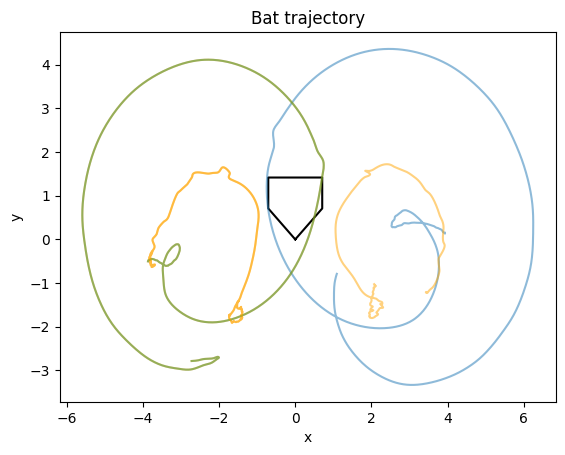

In [106]:
be_handle = ['event','time','head']
be_head = ['event','time','handle']
be = ['time', 'vel', 'acc']

def get_game(id):
    bhead_df = load_game(id, 'samples_bat')
    bhead_df = bhead_df.drop(columns=be_head)
    head_df = pd.json_normalize(bhead_df['head'].to_list())

    bhandle_df = load_game(id, 'samples_bat')
    bhandle_df = bhandle_df.drop(columns=be_handle)
    handle_df = pd.json_normalize(bhandle_df['handle'].to_list())
    return head_df, handle_df

def coords(df):
    split_df = pd.DataFrame(df['pos'].tolist(),index=df.index)

    split_df.columns = ['x','y','z']
    split_df = split_df.drop_duplicates()

    x, y, z = (split_df[coord].to_numpy() for coord in split_df.columns)
    tck, u = splprep([x,y], s=0)
    new_x, new_y = splev(np.linspace(0, 1, 1000), tck)
    
    return new_x, new_y

# base
coord = [[0, 0], [-0.708335, 0.708333], [-0.708335, 1.41667], [0.708335, 1.41667], [0.708335, 0.708333], [0, 0]]
xs, ys = zip(*coord) # split coords into x and y
plt.figure()
plt.plot(xs,ys, color='black') 

head_df, handle_df = get_game(game_ids[0])
head_x, head_y = coords(head_df)
handle_x, handle_y = coords(handle_df)

head_df2, handle_df2 = get_game(game_ids[1])
head_x2, head_y2 = coords(head_df2)
handle_x2, handle_y2 = coords(handle_df2)

head_df3, handle_df3 = get_game(game_ids[2])
head_x3, head_y3 = coords(head_df2)
handle_x3, handle_y3 = coords(handle_df2)

plt.plot(head_x, head_y, alpha=0.5)
plt.plot(handle_x, handle_y, alpha=0.5, color='orange')

plt.plot(head_x2, head_y2, alpha=0.5)
plt.plot(handle_x2, handle_y2, alpha=0.5, color='orange')

plt.plot(head_x3, head_y3, alpha=0.5)
plt.plot(handle_x3, handle_y3, alpha=0.5, color='orange')

plt.title("Bat trajectory")
plt.xlabel("x")
plt.ylabel("y")
plt.show()


We created two functions to get the x and y coordinates from the specific game ids.

In [107]:
avg_headx_df = pd.DataFrame(columns=['x1', 'x2', 'x3', 'x4','x5', 'x6'])
avg_heady_df = pd.DataFrame(columns=['y1', 'y2', 'y3', 'y4','y5', 'y6'])
avg_handlex_df = pd.DataFrame(columns=['x1', 'x2', 'x3', 'x4','x5', 'x6'])
avg_handley_df = pd.DataFrame(columns=['y1', 'y2', 'y3', 'y4','y5', 'y6'])

def get_coords(df, colx, coly, head):
    split_df = pd.DataFrame(df['pos'].tolist(),index=df.index)
    split_df.columns = ['x','y','z']
    split_df = split_df.drop_duplicates()
    split_df = split_df.iloc[:368]
    if (head):
        avg_headx_df[colx] = split_df['x'].values
        avg_heady_df[coly] = split_df['y'].values
    else:
        avg_handlex_df[colx] = split_df['x'].values
        avg_handley_df[coly] = split_df['y'].values

Here is the graph of the average of the dataframes, along with how we calculated it:

In [ ]:
import data
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.interpolate import make_interp_spline, splprep, splev
import json

# plot points
head_df, handle_df = get_game(game_ids[0])
head_df2, handle_df2 = get_game(game_ids[1])
head_df3, handle_df3 = get_game(game_ids[2])
head_df4, handle_df4 = get_game(game_ids[3])
head_df5, handle_df5 = get_game(game_ids[4])
head_df6, handle_df6 = get_game(game_ids[5])
head_df7, handle_df7 = get_game(game_ids[6])

get_coords(head_df, 'x1', 'y1', True)
get_coords(head_df2, 'x2', 'y2', True)
get_coords(head_df3, 'x3', 'y3', True)
get_coords(head_df4, 'x4', 'y4', True)
get_coords(head_df5, 'x5', 'y5', True)
get_coords(head_df6, 'x6', 'y6', True)
get_coords(head_df7, 'x7', 'y7', True)

get_coords(handle_df, 'x1', 'y1', False)
get_coords(handle_df2, 'x2', 'y2', False)
get_coords(handle_df3, 'x3', 'y3', False)
get_coords(handle_df4, 'x4', 'y4', False)
get_coords(handle_df5, 'x5', 'y5', False)
get_coords(handle_df6, 'x6', 'y6', False)
get_coords(handle_df7, 'x7', 'y7', False)

x_avg = avg_headx_df.mean(axis=1)
y_avg = avg_heady_df.mean(axis=1)

head_x = x_avg.tolist()
head_y = y_avg.tolist()

x_avg2 = avg_handlex_df.mean(axis=1)
y_avg2 = avg_handley_df.mean(axis=1)

handle_x = x_avg2.tolist()
handle_y = y_avg2.tolist()

tck, u = splprep([head_x,head_y], s=0)
new_x, new_y = splev(np.linspace(0, 1, 1000), tck)

tck2, u2 = splprep([handle_x,handle_y], s=0)
new_x2, new_y2 = splev(np.linspace(0, 1, 1000), tck2)

# base
coord = [[0, 0], [-0.708335, 0.708333], [-0.708335, 1.41667], [0.708335, 1.41667], [0.708335, 0.708333], [0, 0]]
xs, ys = zip(*coord) # split coords into x and y
plt.figure()
plt.plot(xs,ys, color='black') 

plt.plot(new_x, new_y, alpha=0.75, color='blue')
plt.plot(new_x2, new_y2, alpha=0.75, color='orange')

plt.legend(["home plate", "bat head", "bat handle"], loc="lower right")

plt.title("Bat trajectory")
plt.xlabel("x")
plt.ylabel("y")
plt.show()

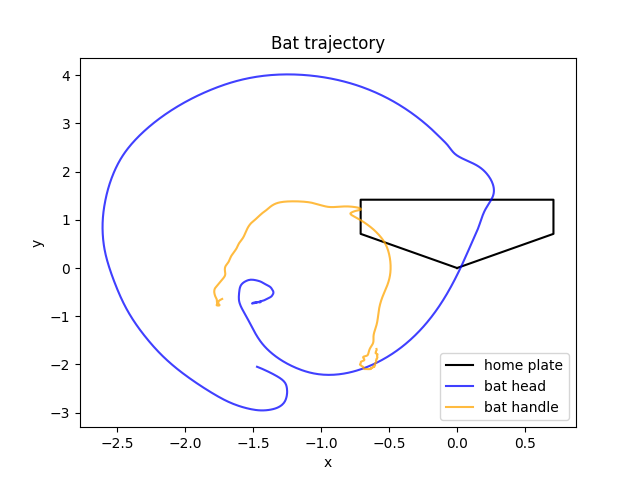

In [109]:
Image(filename='./Figure_1.png')

## Further Analysis
MLB considers the ideal launch angle as the “sweet spot launch angle”, which is between 8-32 degrees. 
https://www.mlb.com/glossary/statcast/launch-angle

Our data was grouped into 3 ranges:
1.	Low launch angle: < 8 degrees
2.	Ideal launch angle: 8-32 degrees
3.	High launch angle: >32 degrees

There are 3 results of a pitch, being a strike, a hitintoplay, or a ball. Strikes are not desirable to the batter because 3 strikes lead to a strikeout, but  hitintoplays and  balls are desirable to the batter since four balls allow the batter to walk to first base. 

Method of analysis: 
1.	Import JSON files into Excel power query.
2.	Parse through JSON, creating columns for pitch results and angle. 
•	Since at bats that did not have hits were empty in “Events,” filtered out the rows that were null, then expanded “Events” to angles. 
3.	Since launch angle is in the second index of the angles list, create a new column indicating the row indices.
4.	Filter out the rows with odd indices, leaving only the launch angle behind in the angles column. 
5.	Determine % of strikes, % of hitintoplays, and % of balls for each launch angle range. 
The results from the data are:

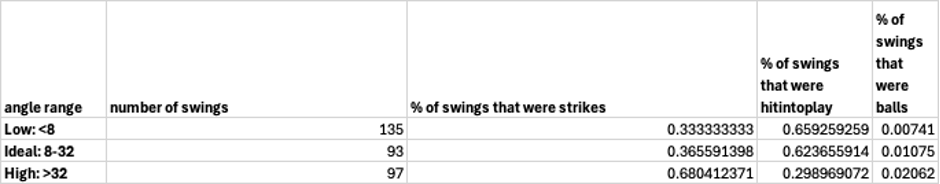

In [ ]:
from IPython.display import Image

From Figure 1, the percentage of strikes from low and ideal launch angles were similar, being around 33-36%. However, the percentage of strikes was significantly higher for launch angles >32, being 68%. The percentage of hitintoplays decreased as launch angle increased, and the percentage of balls increased as launch angle increased. 

The increase in the percentage of strikes as the launch angles increases, supports the findings from the University of Illinois, where “If the batter aims to get on base and secure as many hits as possible with minimal strikeouts, then he should aim for a lower attack angle (resulting in a low peak launch angle). Conversely, if the batter prioritizes hitting as many home runs as possible and is less concerned about striking out, then he should aim for a higher attack angle (resulting in a high peak launch angle).” 
https://baseball.physics.illinois.edu/PeakLaunchAngle.pdf 

The hits from the ideal launch angle range show a significantly lower percentage of strikes than the high launch angle range, while also having a significantly larger percentage of hitintoplays than that of the high launch angle range. The high launch angles only had 30% of hitintoplays, while the ideal launch angle range had 62% of hitintoplays. Thus, the “sweet spot launch angle,” defined by the MLB is likely to lead to more hitintoplays while minimizing strikes. 